# Image Reconstruction

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('client')
#pv.OFF_SCREEN=True

In [2]:
import time

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc
import cedalion.datasets
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion.plots
from cedalion.imagereco.solver import pseudo_inverse_stacked

xr.set_options(display_expand_data=False);

## Load a finger-tapping dataset 

For this demo we load an example finger-tapping recording through `cedalion.datasets.get_fingertapping`. The file contains a single NIRS element with one block of raw amplitude data. 

In [3]:
rec = cedalion.datasets.get_fingertapping()

The location of the probes is obtained from the snirf metadata (i.e. /nirs0/probe/)

Note that units ('m') are adopted and the coordinate system is named 'digitized'.

In [4]:
geo3d_meas = rec.geo3d
display(geo3d_meas)

Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815] [0.06938013615060833 0.0069016618704050535 0.10806432085401242] [0.07932239267332403 -0.00044800545870984573 0.08903670686337778] [0.07756024143390347 0.022515587935674892 0.08578432016555051] [0.07912303758068968 0.036496511669642975 0.06257633565753129] [0.08225821050778642 0.01751423306824721 0.06619028345490524]]
Units,meter


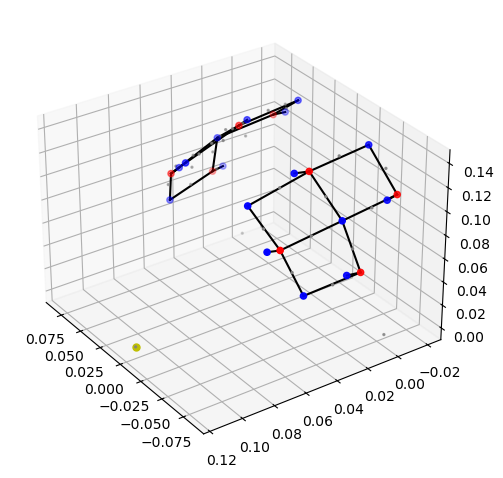

In [5]:
cedalion.plots.plot_montage3D(rec["amp"], geo3d_meas)

The measurement list is a `pandas.DataFrame` that describes which source detector pairs form channels.

In [6]:
meas_list = rec._measurement_lists["amp"]
display(meas_list.head(5))

,sourceIndex,detectorIndex,wavelengthIndex,wavelengthActual,wavelengthEmissionActual,dataType,dataUnit,dataTypeLabel,dataTypeIndex,sourcePower,detectorGain,moduleIndex,sourceModuleIndex,detectorModuleIndex,channel,source,detector,wavelength,chromo
0,1,1,1,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,760.0,None
1,1,1,2,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,850.0,None
2,1,2,1,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,760.0,None
3,1,2,2,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,850.0,None
4,1,3,1,None,None,1,None,None,1,None,None,None,None,None,S1D3,S1,D3,760.0,None


Event/stimulus information is also stored in a `pandas.DataFrame`. Here events are given more descriptive names:

In [7]:
rec.stim.cd.rename_events( {
        "1.0" : "control",
        "2.0" : "Tapping/Left",
        "3.0" : "Tapping/Right"
})
display(rec.stim.groupby("trial_type")[["onset"]].count())

,onset
trial_type,
15.0,2
Tapping/Left,30
Tapping/Right,30
control,30


(for this demo select 20 seconds after a trial starts at t=117s and transform raw amplitudes to optical density)

Transform CW raw amplitudes to optical density

In [8]:
raw_amp = rec["amp"]
rec["od"] = -np.log( raw_amp/ raw_amp.mean("time"))
display(rec["od"])

Magnitude,[[[0.040420720851589244 0.04460046098449573 0.0442158667266921 ... 0.010876348689028297 0.01189058853204466 0.006847636450666034] [0.023820496835156947 0.020076986081598715 0.03480909472899116 ... 0.023992850639162802 0.027040875264083337 0.031732993935654014]] [[-0.008280063468686781 -0.01784405593180633 -0.002198739340328898 ... -0.003592058220542012 -0.006742726672860488 -0.0047443982578777594] [-0.03725579234490354 -0.04067296052603699 -0.028261149412724014 ... 0.008275386235838757 0.005771141488662178 0.0051515177576299375]] [[0.1005582275517943 0.09914287354277777 0.11119025710690507 ... -0.02830701101541003 -0.023242770227372977 -0.023590421283804962] [0.04993799639529682 0.047551763623795935 0.06016311306879892 ... -0.005456229532249399 -0.0015308884573803712 -0.004733085331725723]] ... [[0.09543410489184105 0.11098678842280141 0.10684828479073329 ... -0.038599718102985896 -0.03566192105523218 -0.04378947818067423] [0.03858010875753767 0.06286432773409747 0.06128249638988582 ... 0.008314104856099373 0.007674359302522161 -0.0026751405572218796]] [[0.15506580435158798 0.17214467649471782 0.16880746748060918 ... -0.06854981498765861 -0.06838218329243445 -0.07333574448986935] [0.10250044669095155 0.12616269025036977 0.1261907782199553 ... -0.040611038136814874 -0.040371126750177955 -0.04750589562552556]] [[0.0580532188103781 0.06125157285758024 0.06083507429037254 ... -0.019157798285875216 -0.019003174994086804 -0.020343916456372766] [0.02437701777814723 0.030886638430615728 0.03219054575814673 ... -0.01108594305570406 -0.010936510768482734 -0.013167265399560904]]]
Units,dimensionless


## Calculate block averages in optical density

In [9]:
rec["od_freqfiltered"] = rec["od"].cd.freq_filter(fmin=0.02, fmax=0.5, butter_order=4)

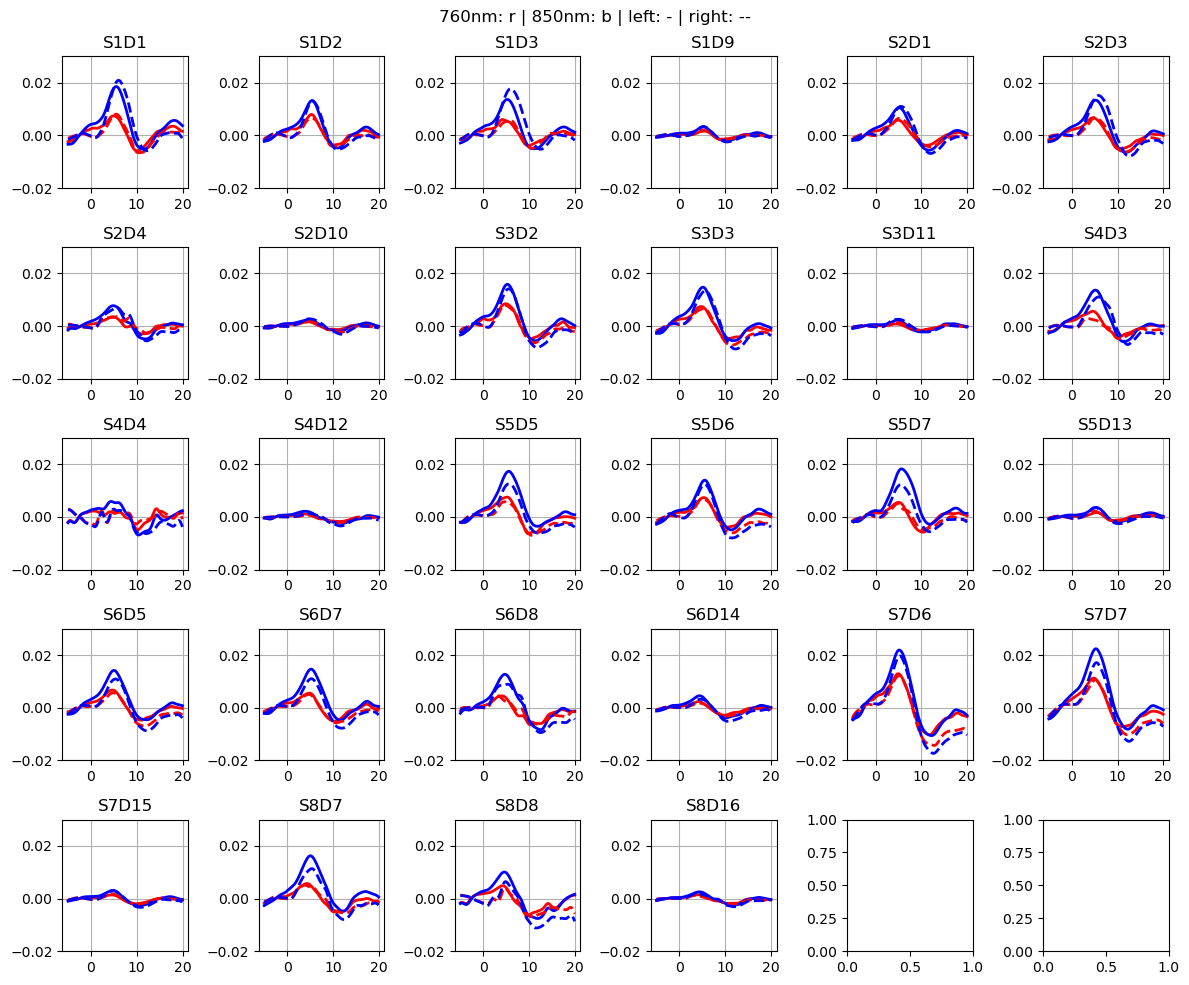

In [10]:
epochs = rec["od_freqfiltered"].cd.to_epochs(
        rec.stim, # stimulus dataframe
        ["Tapping/Left", "Tapping/Right"],  # select events
        before=5, # seconds before stimulus
        after=20  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")
# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = epochs_blcorrected.groupby("trial_type").mean("epoch")

# show results
f,ax = p.subplots(5,6, figsize=(12,10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):    
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=760, trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=850, trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-.02, .03)
    

p.suptitle("760nm: r | 850nm: b | left: - | right: --")
p.tight_layout()



## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain.

In [11]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()

The segmentation masks are in individual niftii files. The dict `mask_files` maps mask filenames relative to `SEG_DATADIR` to short labels. These labels describe the tissue type of the mask. 

In principle the user is free to choose these labels. However, they are later used to lookup the tissue's optical properties. So they must be map to one of the tabulated tissue types (c.f. `cedalion.imagereco.tissue_properties.TISSUE_LABELS`).

The variable `landmarks_file` holds the path to a file containing landmark positions in scanner space (RAS). This file can be created with Slicer3D.

In [12]:
display(SEG_DATADIR)
display(mask_files)
display(landmarks_file)

'/Users/shakiba/Library/Caches/cedalion/ICBM152(2020).zip.unzip/ICBM152(2020)'

{'csf': 'mask_csf.nii',
 'gm': 'mask_gray.nii',
 'scalp': 'mask_skin.nii',
 'skull': 'mask_bone.nii',
 'wm': 'mask_white.nii',
 'air': 'mask_air.nii',
 'parcels': 'parcellation_mask_600.nii'}

'landmarks.mrk.json'

## Coordinate systems

Up to now we have geometrical data from three different coordinate reference systems (CRS):

- The optode positions are in one space `CRS='digitized'` and the coordinates are in meter. In our example the origin is at the head center and y-axis pointing in the superior direction. Other digitization tools can use other units or coordinate systems.
- The segmentation masks are in voxel space (`CRS='ijk'`) in which the voxel edges are aligned with the coordinate axes. Each voxel has unit edge length, i.e. coordinates are dimensionless. 
  Axis-aligned grids are computationally efficient, which is why the photon simulation code (MCX) uses this coordinate system.
- The voxel space (`CRS='ijk'`) is related to scanner space (`CRS='ras'` or `CRS='aligned'`) in which coordinates have physical units and coordinate axes point to the (r)ight, (a)nterior and s(uperior) directions. The relation between both spaces is given through an affine transformation (e.g. `t_ijk2ras`). When loading the segmentation masks in Slicer3D this transformation is automatically applied. Hence, the picked landmark coordinates are exported in RAS space.

  The niftii file provides a string label for the scanner space. In this example the RAS space is called 'aligned' because the masks are aligned to another MRI scan.


To avoid confusion between these different coordinate systems, `cedalion` tries to be explicit about which CRS a given point cloud or surface is in.

## The TwoSurfaceHeadModel

The photon propagation considers the complete MRI scan, in which each voxel is attributed to one tissue type with its respective optical properties. However, the image reconstruction does not intend to reconstruct absorption changes in each voxel. The inverse problem is simplified, by considering only two surfaces (scalp and brain) and reconstruct only absorption changes in voxels close to these surfaces.

The class `cedalion.imagereco.forward_model.TwoSurfaceHeadModel` groups together the segmentation mask, landmark positions and affine transformations as well as the scalp and brain surfaces. The brain surface is calculated by grouping together white and gray matter masks. The scalp surface encloses the whole head.

In [13]:
mask_files.pop("air")
mask_files.pop("parcels")
head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)

In [14]:
head.segmentation_masks

<xarray.DataArray (segmentation_type: 5, i: 193, j: 239, k: 263)> Size: 61MB
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * segmentation_type  (segmentation_type) <U5 100B 'csf' 'gm' ... 'skull' 'wm'
Dimensions without coordinates: i, j, k

In [15]:
head.landmarks

Magnitude,[[96.00000000000104 218.10000000000133 108.0000000000015] [95.99999999999906 18.899999999999324 100.99999999999925] [15.899999999999935 120.00000000000044 102.00000000000051] [178.10000000000025 120.00000000000028 103.00000000000031]]
Units,dimensionless


In [16]:
head.brain

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(89768, 3), faces.shape=(180000, 3))>, crs='ijk', units=<Unit('dimensionless')>)

In [17]:
head.scalp

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(30141, 3), faces.shape=(59999, 3))>, crs='ijk', units=<Unit('dimensionless')>)

`TwoSurfaceHeadModel.from_segmentation` converts everything into voxel space (`CRS='ijk'`)

In [18]:
head.crs

'ijk'

The transformation matrix to translate from voxel to scanner space:

In [19]:
head.t_ijk2ras

Magnitude,[[1.0 0.0 0.0 -96.0] [0.0 1.0 0.0 -132.0] [0.0 0.0 1.0 -148.0] [0.0 0.0 0.0 1.0]]
Units,millimeter


Changing between coordinate systems:

In [20]:
head_ras = head.apply_transform(head.t_ijk2ras)
display(head_ras.crs)
display(head_ras.brain)

'aligned'

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(89768, 3), faces.shape=(180000, 3))>, crs='aligned', units=<Unit('millimeter')>)

## Optode Registration
The optode coordinates from the recording must be aligned with the scalp surface. Currently, `cedaĺion` offers a simple registration method, which finds an affine transformation (scaling, rotating, translating) that matches the landmark positions of the head model and their digitized counter parts. Afterwards, optodes are snapped to the nearest vertex on the scalp.

In [21]:
geo3d_snapped_ijk = head.align_and_snap_to_scalp(geo3d_meas)
display(geo3d_snapped_ijk)

Magnitude,[[54.85444756493949 135.7704517827475 231.43019273192118] [34.928058590683534 167.00374576983998 192.8100602307299] [21.68278577050374 97.25349340105278 208.030895992947] [14.732585384690964 131.8934101567271 165.0603016259684] [133.66707504179584 138.12028568821034 233.06581287992833] [155.83116713924306 169.4137062110982 192.0179987122823] [170.42228312214365 98.99177755447445 208.01761644762308] [177.071679843237 132.12625031922812 166.10686291514358] [58.976426247165634 172.90333298447308 215.36217411439978] [49.68844210785649 99.26058483855473 236.82173512006864] [25.934877807071572 136.1459981739858 201.64701127104428] [22.699192464447886 163.01613374537828 158.00715213261657] [130.01071021174846 172.30983996346555 217.73494992645936] [138.2776781686535 100.76247447007388 238.7967787628454] [166.43008651067427 133.76415746142885 202.15317779239643] [168.37956735408468 165.1300390434512 160.1223894696758] [59.84827965505072 143.76377116043767 231.42995115954074] [38.26995768328747 174.93822862187065 190.4411136923814] [21.68833079018136 106.23401566485866 208.02009623199692] [15.895181573235298 139.0206359901417 165.72333321583142] [136.66701766249474 133.12035148451804 233.06618622695288] [159.07297226094647 163.8102507759961 192.00306169015303] [168.32857546464004 92.0083732561289 210.02801937236842] [178.3309353908134 124.9717112957465 168.07307418784865] [15.935015306653177 117.0806601136243 100.10526757663813] [95.9811064953761 217.11883051148166 108.17386230045163] [176.0598522658896 118.99117401958082 102.98885613775153] [56.8453878965463 155.76096462219328 224.41690420582867] [51.836838977372146 121.76655718114468 234.4409286527714] [36.8940857544643 137.80062079591116 215.30239482423107] [137.68766187895199 142.10135394829453 229.06968483520933] [46.11489167412357 171.2604117159941 204.93333223819675] [28.91974757904798 151.97990475581517 195.84304301633045] [27.107461454123747 166.74941018558798 174.4669151970906] [128.90575602300328 168.0377859451334 221.34592372321407] [35.61215385828973 94.02406654633248 224.86312554228024] [20.936536126049965 117.01484894867636 203.5984347431331] [122.91020038112053 115.00266235070147 244.26347766533087] [17.667610184391883 135.1078214746022 181.00227615193472] [17.70169198870814 145.98107403604206 158.96037043498598] [122.90082619876716 155.02597329987861 231.38432837498567] [133.89595475064434 157.36650192948585 224.85815987508232] [136.03143089838932 119.02092254338214 237.41860532232664] [150.23657454865116 137.89820216253435 220.69350027881146] [165.88470744598254 133.46857581256896 203.75245315624574] [144.40518752376704 170.77188801072793 207.0265878616348] [161.8949589995209 153.4588159135128 196.7628987464641] [163.07186056579485 167.66785830154768 178.12224725541734] [170.3708445391194 149.12289319645362 180.11143666468465] [151.27904160862238 99.77176566508916 229.7868425053693] [169.7574880061985 119.03183474779613 205.1795984461374] [177.07698952576533 112.14907534294903 189.12629327077178] [173.33885894923807 135.0074887700013 185.1052649725367] [173.30560594181708 149.01347532448142 164.22717728073206] [177.071679843237 132.12625031922812 166.10686291514358]]
Units,dimensionless


In [22]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

Widget(value='<iframe src="http://localhost:63107/index.html?ui=P_0x304565ed0_0&reconnect=auto" class="pyvista…

## Simulate light propagation in tissue

`cedalion.imagereco.forward_model.ForwardModel` is a wrapper around pmcx. Using the data in the head model it prepares the inputs for either pmcx or NIRFASTer and offers functionality to calculate the sensitivty matrix.

In [23]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, meas_list)

### Run the simulation

The `compute_fluence_mcx` and `compute_fluence_nirfaster` methods simulate a light source at each optode position and calculate the fluence in each voxel. By setting `RUN_PACKAGE`, you can choose between the pmcx or NIRFASTer package to perform this simulation.

In [24]:
USE_CACHED = False
RUN_PACKAGE = 'NIRFASTer' # or 'MCX'

if USE_CACHED:
    fluence_all, fluence_at_optodes = cedalion.datasets.get_parcel_example_fluence()
else:
    if RUN_PACKAGE == 'MCX':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()
    elif RUN_PACKAGE == 'NIRFASTer':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_nirfaster()

Running CGAL mesher
Meshing...

Running local optimization...

 Removed 17 unused nodes from mesh!

Converting to NIRFAST format
Calculating the MASS matrix
Solving the system


The photon simulation yields the fluence in each voxel for each wavelength.

In [25]:
fluence_all

<xarray.DataArray (label: 24, wavelength: 2, i: 193, j: 239, k: 263)> Size: 5GB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * label       (label) <U3 288B 'S1' 'S2' 'S3' 'S4' ... 'D13' 'D14' 'D15' 'D16'
    type        (label) object 192B PointType.SOURCE ... PointType.DETECTOR
  * wavelength  (wavelength) float64 16B 760.0 850.0
Dimensions without coordinates: i, j, k

Also, for a each combination of two optodes, the fluence in the voxels at the optode positions is calculated.

In [26]:
fluence_at_optodes

<xarray.DataArray (optode1: 24, optode2: 24, wavelength: 2)> Size: 9kB
0.06768 0.06768 1.068e-08 1.068e-08 ... 2.142e-09 2.142e-09 0.08137 0.08137
Coordinates:
  * optode1     (optode1) <U3 288B 'S1' 'S2' 'S3' 'S4' ... 'D14' 'D15' 'D16'
  * optode2     (optode2) <U3 288B 'S1' 'S2' 'S3' 'S4' ... 'D14' 'D15' 'D16'
  * wavelength  (wavelength) float64 16B 760.0 850.0

## Plot fluence

To illustrate the tissue probed by light travelling from a source to the detector two fluence profiles need to be multiplied. 

In [27]:
time.sleep(1)

plt = pv.Plotter()

f = fluence_all.loc["S1", 760].values * fluence_all.loc["D1",760].values
f[f<=0] = f[f>0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300,30, 150]
plt.camera.focal_point = cog 
plt.camera.up = [0,0,1] 

plt.show()

/opt/anaconda3/envs/cedalion_dev/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Widget(value='<iframe src="http://localhost:63107/index.html?ui=P_0x34583fd90_1&reconnect=auto" class="pyvista…

### Calculate the sensitivity matrices

The sensitivity matrix describes the effect of an absorption change at a given surface vertex in the OD recording in a given channel and at given wavelength. The coordinate `is_brain` holds a mask to distinguish brain and scalp voxels.

In [28]:
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
Adot

<xarray.DataArray (channel: 28, vertex: 119909, wavelength: 2)> Size: 54MB
1.236e-18 1.236e-18 1.328e-17 1.328e-17 ... 6.116e-17 6.116e-17 0.0 0.0
Coordinates:
  * channel     (channel) <U5 560B 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
  * wavelength  (wavelength) float64 16B 760.0 850.0
    is_brain    (vertex) bool 120kB True True True True ... False False False
Dimensions without coordinates: vertex

### Plot Sensitivity Matrix

In [32]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

sensitivity_matrix = Adot.where(Adot['is_brain'], drop=True)
sensitivity_matrix = sensitivity_matrix.sel(wavelength = 760).sum(dim='channel').values


sensitivity_matrix[sensitivity_matrix<=0] = sensitivity_matrix[sensitivity_matrix>0].min()
sensitivity_matrix = np.log10(sensitivity_matrix)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pyvista as pv

# Original colormap
cmap = plt.cm.get_cmap("jet", 256)


gray = [1, 1, 1, 1]  # RGBA for gray
new_cmap_colors = np.vstack((gray, cmap(np.linspace(0, 1, 255))))
custom_cmap = ListedColormap(new_cmap_colors)

# Plot using PyVista
plotter = pv.Plotter()
plotter.add_mesh(b, scalars=sensitivity_matrix, cmap=custom_cmap, clim=(-3, 0))

# Add a scalar bar
# plotter.add_scalar_bar(title='Sensitivity', label_font_size=12, shadow=True)

# Show the plot
plotter.show()


/var/folders/82/14s7dkbx0ys8_nfvyj9009180000gn/T/ipykernel_58362/3491419071.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", 256)


Widget(value='<iframe src="http://localhost:63107/index.html?ui=P_0x34fb031d0_3&reconnect=auto" class="pyvista…

In [31]:
sensitivity_matrix = Adot.where(Adot['is_brain'], drop=True)
sensitivity_matrix = sensitivity_matrix.sel(wavelength = 760).sum(dim='channel').values
sensitivity_matrix.max()

0.9139297862949932

In [ ]:
plt = pv.Plotter()

f = fluence_all.loc["S1", 760].values * fluence_all.loc["D1",760].values
f[f<=0] = f[f>0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300,30, 150]
plt.camera.focal_point = cog 
plt.camera.up = [0,0,1] 

plt.show()

The sensitivity `Adot` has shape (nchannel, nvertex, nwavelenghts). To solve the inverse problem we need a matrix that relates OD in channel space to absorption in image space. Hence, the sensitivity must include the extinction coefficients to translate between OD and concentrations. Furthermore, channels at different wavelengths must be  stacked as well vertice and chromophores into new dimensions (flat_channel, flat_vertex):

$$ \left( \begin{matrix} OD_{c_1, \lambda_1} \\ \vdots \\ OD_{c_N,\lambda_1} \\ OD_{c_1,\lambda_2} \\ \vdots \\ OD_{c_N,\lambda_2} \end{matrix}\right) = A \cdot
\left( \begin{matrix} \Delta c_{v_1, HbO} \\ \vdots \\ \Delta c_{v_N, HbO} \\ \Delta c_{v_1, HbR} \\ \vdots \\ \Delta c_{v_N, HbR} \end{matrix}\right) $$

In [29]:
Adot_stacked = fwm.compute_stacked_sensitivity(Adot)
Adot_stacked

/opt/anaconda3/envs/cedalion_dev/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


<xarray.DataArray (flat_channel: 56, flat_vertex: 240474)> Size: 108MB
0.0 0.0 4.016e-13 0.0 2.163e-13 ... 2.035e-15 0.0 5.028e-18 7.996e-18 1.198e-16
Dimensions without coordinates: flat_channel, flat_vertex

### Invert the sensitivity matrix

In [ ]:
B = pseudo_inverse_stacked(Adot_stacked)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")
B

### Calculate concentration changes

- the optical density has shape (nchannel, nwavelength, time) -> stack channel and wavelength dimension into new flat_channel dimension

In [ ]:
blockaverage

In [ ]:
od_stacked = blockaverage.stack({"flat_channel" : ["wavelength", "channel"]})
display(od_stacked)

multiply with the inverted sensitivity matrix. contracts over flat_channel and the flat_vertex dimension remains

In [ ]:
dC = B @ od_stacked
dC

## Plot concentration changes

Using functionality from pyvista and VTK plot the concentration changes on the brain surface

In [ ]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

In [ ]:
# plot brain surface

for trial_type, gif_fname in [("Tapping/Left", "hbo_left.gif"), ("Tapping/Right", "hbo_right.gif")]:

    hbo = dC.sel(chromo="HbO", trial_type=trial_type).pint.dequantify() / 1e-6 # FIXME unit handling
    hbo_brain = hbo[(Adot.is_brain == True).values,:]

    ntimes = hbo.sizes["reltime"]

    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)
    b["reco_hbo"] = (hbo_brain[:,0] - hbo_brain[:,0])

    plt = pv.Plotter()

    plt.add_mesh(
        b,
        scalars="reco_hbo",
        cmap='seismic', # 'gist_earth_r', 
        clim=(-0.3,0.3),
        scalar_bar_args = {"title" : "HbO / µM"}
    )

    cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)


    tl = lambda tt : f"{trial_type} HbO rel. time: {tt:.3f} s"
    time_label = plt.add_text(tl(0))

    cog = head.brain.vertices.mean("label").values
    plt.camera.position = cog + [0,0,400]
    plt.camera.focal_point = cog 
    plt.camera.up = [0,1,0] 
    plt.reset_camera()

    plt.open_gif(gif_fname)

    for i in range(0,ntimes,3):
        b["reco_hbo"] = (hbo_brain[:,i] - hbo_brain[:,0])
        time_label.set_text("upper_left", tl(hbo_brain.reltime[i]))

        plt.write_frame()

    plt.close()

In [ ]:
display(Image(data=open("hbo_left.gif",'rb').read(), format='png'))
display(Image(data=open("hbo_right.gif",'rb').read(), format='png'))